## Nutrient Demands



### Introduction



In our last project we used data to estimate systems of food demand
using different datasets.  An output from that project was as set of
`cfe.Regression` objects; these bundle together both data and the results
from the demand system estimation, and can be used for prediction as
well.

Here we&rsquo;ll explore some of the uses of the `cfe.Regression` class, using
an instance created previously (as in Project 3).

After having estimated a demand system using data from our favorite country, we can imagine different counterfactual scenarios.  What if prices were different?  What if we give a cash transfer to a household?  What if school fees reduce the budget for food?  What are the consequences of any of these for diet & nutrition?

If you don&rsquo;t already have the latest version of the `CFEDemands` package
installed, grab it, along with some dependencies:



In [1]:
#%pip install -r requirements.txt

In [60]:
import pandas as pd
import cfe.regression as rgsn
import numpy as np
import matplotlib.pyplot as plt
from eep153_tools.sheets import read_sheets

### From Sheet to DataFrame to Regression Object



We begin by defining a dictionary that contains the spreadsheet key.
One is provided for the Ugandan example that I wish to work
through.



In [136]:
tanz_data = 'https://docs.google.com/spreadsheets/d/1t7oTB6FAdzu34SdNKCMK8rUoin8TeeKq1wt2fu4VBho/edit?usp=sharing'

With the spreadsheet defined , grab it and define a couple of
dataframes. (Sheets should be shared with `students@eep153.iam.gserviceaccount.com`):



In [137]:

x = read_sheets(tanz_data,sheet='Food Expenditures (2020-21)')
x = x.set_index(['i','t','m','j']).squeeze()


# Now prices
p = read_sheets(tanz_data,sheet='Food Prices (2020-21)')
p = p[p['u'] == 'kg'].set_index(['t','m','j','u'])
print(p)
# Compute medians of prices for particular time, place and unit
p = p.groupby(['t','m','j','u']).median()
print(p)
# Just keep metric units
p = p.xs('kg',level="u").squeeze().unstack('j')

# Get intersection of goods we have prices *and* expenditures for:
jidx = p.columns.intersection(x.index.levels[-1])

# Drop prices for goods we don't have expenditures for
p = p[jidx].T

# Household characteristics
d = read_sheets(tanz_data,sheet="Household Characteristics")
d.columns.name = 'k'

# Fill blanks with zeros
d = d.replace(np.nan,0)

# Expenditures x may have duplicate columns
x = x.T.groupby(['i','t','m','j']).sum()
x = x.replace(0,np.nan) # Replace zeros with missing

# Take logs of expenditures; call this y
y = np.log(x)

d.set_index(['i','t','m'],inplace=True)

                                                          Price
t       m             j                        u               
2020-21 Dar Es Salaam Beef                     kg   7526.388889
                      Bread                    kg   2971.958787
                      Buns, Cakes And Biscuits kg   2479.066073
                      Cassava Dry/Flour        kg   1000.000000
                      Cassava Fresh            kg    974.443404
...                                                         ...
        Zanzibar      Sweets                   kg  29861.111110
                      Tea (dry)                kg  10000.000000
                      Vegetables (fresh)       kg   1795.731922
                      Wheat Flour              kg   1494.400000
                      Yams/Cocoyams            kg    666.666667

[191 rows x 1 columns]
                                                          Price
t       m             j                        u               
2020-21 Dar Es S

This gives a dataframe of household characteristics $d$ with a simple structure.



Also a dataframe of log expenditures $y$ with a similarly simple
structure.  Note that any expenditures of zero are dropped and
replaced with a missing value indicator.



Finally, construct a regression object:



In [127]:
r = rgsn.Regression(y=y,d=d)
r.predicted_expenditures()

i            t        m                     j                 
1009-001-01  2020-21  Mainland Rural        Beef                  7621.380622
                                            Bread                 3116.362048
                                            Citrus Fruits         2386.790062
                                            Coconuts              3764.144393
                                            Cooking Oil           2890.625069
                                                                     ...     
9808-001-99  2020-21  Mainland Other Urban  Soft drinks           3934.514624
                                            Sugar                 3745.254869
                                            Tea (dry)              538.494243
                                            Vegetables (fresh)    2791.539851
                                            Wheat Flour           2819.741945
Length: 8580, dtype: float64

In [128]:
r.to_pickle('tanz_rgsn')

### Additional Data



Using the data on household characteristics and (log) expenditures, we can estimate the demand system (`d`,=y=).  This gives us predictions of expenditures on different kinds of foods.  Then if we divide these expenditures by prices, we get predicted quantities of food.

However, here we&rsquo;re interested in nutritional outcomes, so we need a food conversion table:



In [138]:
fct = read_sheets(tanz_data,sheet='FCT')

fct = fct.set_index('j')
fct.columns.name = 'n'

fct = fct.apply(lambda x: pd.to_numeric(x,errors='coerce'))

In [135]:
fct.to_csv('fctsave')

We also want to establish when nutrition is *adequate* for households with different compositions.  For this, we want data on recommended dietary intakes:



In [139]:
rdi = read_sheets(tanz_data,sheet='RDI')

rdi = rdi.set_index('n')
rdi.columns.name = 'k'

rdi = rdi.apply(lambda x: pd.to_numeric(x,errors='coerce'))

In [134]:
rdi.to_csv('rdisave')

#### Pre-estimated Demand Systems



An instance `r` of `cfe.Regression` can be made persistent with
 `r.to_pickle('my_result.pickle')`, which saves the instance &ldquo;on disk&rdquo;, and can be loaded using `cfe.regression.read_pickle`.  We use  this method below to load data and demand system previously estimated for Uganda:



In [25]:
# Assumes you've already set this up e.g., in Project 3
r = rgsn.read_pickle('tanz_rgsn')

#### Reference Prices



Choose reference prices.  Here we&rsquo;ll choose a particular year, and average prices across markets.  If you wanted to focus on particular market you&rsquo;d do this differently.



In [27]:
fct

n,Energy,Protein,Vitamin A,Vitamin D,Vitamin E,Vitamin C,Vitamin B-6,Vitamin B-12,Calcium,Magnesium,Iron,Zinc
j,,,,,,,,,,,,
Beef,3230,249,0,0,0,0,3,19,40,230,17,41
Bottled beer,410,3,0,0,0,0,1,0,50,60,0,0
Bread,2740,80,0,0,0,0,0,0,100,270,5,9
Butter,8760,3,9250,20,30,0,0,0,80,10,1,0
Canned milk/milk powder,4960,263,4070,0,0,70,4,30,8510,810,7,30
...,...,...,...,...,...,...,...,...,...,...,...,...
"Wheat, barley grain and other cereals",3490,123,0,0,10,0,2,0,260,920,28,20
"Wheat, barley, other grains",3490,123,0,0,10,0,2,0,260,920,28,20
Wild birds and insects,0,0,0,0,0,0,0,0,0,0,0,0


In [140]:
# Reference prices chosen from a particular time; average across place.
# These are prices per kilogram:
pbar = p.loc[r.beta.index].mean(axis=1).fillna(1) # Only use prices for goods we can estimate

In [132]:
pbar.to_csv('pbarsave')

In [144]:
rdi.to_csv('newrdi')

In [141]:
scenariopbar = []

In [146]:
pbar.to_pickle('pbar.pkl')
fct.to_pickle('fct.pkl')
rdi.to_pickle('rdi.pkl')
x.to_pickle('x.pkl')

In [147]:
x.to_pickle('x.pkl')

In [142]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output
from ipywidgets import GridBox, Label, Layout


# 1) Build per‐food widgets from pbar.index
food_mult_widgets = {
    j: widgets.FloatText(value=1.0, description='', layout=Layout(width='100px'))
    for j in pbar.index
}

# 2) Global × widget
system_shock = widgets.FloatText(value=1.0, description='Global ×', layout=Layout(width='200px'))

# 3) Per‐nutrient tax widgets from fct.columns
nut_tax_widgets = {
    n: widgets.FloatText(value=0.0, description=n, layout=Layout(width='300px'))
    for n in fct.columns
}

# 4) Reset & output
reset_button = widgets.Button(description='Reset All', button_style='warning')
output = widgets.Output()

# 5) Build 2-col GridBox of food multipliers
labels = [Label(j, layout=Layout(width='200px', justify_content='center')) for j in pbar.index]
inputs = [food_mult_widgets[j] for j in pbar.index]
grid = GridBox(
    children=[val for pair in zip(labels, inputs) for val in pair],
    layout=Layout(
        grid_template_columns='200px 100px',
        grid_row_gap='4px',
        grid_column_gap='8px',
        overflow='auto',
        height='600px',
        width='320px'
    )
)

# 6) Update callback
def update_prices(change=None):
    with output:
        clear_output(wait=True)
        fm = pd.Series({j: w.value for j,w in food_mult_widgets.items()},
                       index=pbar.index)
        sys = system_shock.value
        nt  = pd.Series({n: w.value for n,w in nut_tax_widgets.items()})

        base_price = pbar * fm * sys

        tax_vec = (
            fct
            .mul(nt, axis=1)
            .sum(axis=1)
            .reindex(pbar.index)
            .fillna(0.0)
        )

        newp = base_price + tax_vec
        display(newp)

# 7) Reset callback
def on_reset_widgets(_):
    # reset the global shock
    system_shock.value = 1.0
    # reset every food multiplier back to 1
    for w in food_mult_widgets.values():
        w.value = 1.0
    # reset every nutrient tax/subsidy back to 0
    for w in nut_tax_widgets.values():
        w.value = 0.0

reset_button.on_click(on_reset_widgets)


# 8) Wire up observers
for w in list(food_mult_widgets.values()) + [system_shock] + list(nut_tax_widgets.values()):
    w.observe(update_prices, names='value')

# 9) Tabs layout
tab_food = widgets.VBox([system_shock, grid], layout=Layout(align_items='flex-start'))
tab_nut  = widgets.VBox(list(nut_tax_widgets.values())+[reset_button], layout=Layout(overflow='auto',height='600px'))
tabs     = widgets.Tab([tab_food, tab_nut])
tabs.set_title(0,"Food Multipliers"); tabs.set_title(1,"Nutrient Tax/Subsidy")

# 10) Display
# after your tabs & update_prices definitions…

# 1) helper
def compute_updated_pbar():
    fm = pd.Series({j: w.value for j, w in food_mult_widgets.items()}, index=pbar.index)
    sys = system_shock.value
    nt = pd.Series({n: w.value for n, w in nut_tax_widgets.items()})
    base_price = pbar * fm * sys
    tax_vec = (
        fct
        .mul(nt, axis=1)
        .sum(axis=1)
        .reindex(pbar.index)
        .fillna(0.0)
    )
    return base_price + tax_vec

# 2) apply button
apply_btn = widgets.Button(description="Apply as new pbar", button_style='success')
reset_btn = widgets.Button(description="Reset to base case", button_style='success')
def on_apply(_):
    global scenariopbar
    scenariopbar = compute_updated_pbar()
    print("scenariopbar updated.")
apply_btn.on_click(on_apply)
reset_btn.on_click(on_reset_widgets)
display(apply_btn)
display(reset_btn)
display(tabs, output)
update_prices()


Button(button_style='success', description='Apply as new pbar', style=ButtonStyle())

Button(button_style='success', description='Reset to base case', style=ButtonStyle())

Output()

#### Budgets



Get food budget for all households, then find median budget:



In [33]:
import numpy as np

xhat = r.predicted_expenditures()

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
xref = xbar.quantile(0.5)  # Household at 0.5 quantile is median

#### Food Quantities



Get quantities of food by dividing expenditures by prices:



In [34]:
qhat = (xhat.unstack('j')/pbar).dropna(how='all')

# Drop missing columns
qhat = qhat.loc[:,qhat.count()>0]

qhat

,,j,Beef,Bread,Citrus Fruits,Coconuts,Cooking Oil,Eggs,Fish (fresh),Irish Potatoes,Leafy Greens,Maize (flour),...,Plantains,Pulses,Rice (husked),Ripe Bananas,Salt,Soft drinks,Sugar,Tea (dry),Vegetables (fresh),Wheat Flour
i,t,m,,,,,,,,,,,,,,,,,,,,,
1009-001-01,2020-21,Mainland Rural,0.989583,1.137633,1.657478,2.702072,0.605272,0.366246,1.002811,2.375649,1.451940,4.814558,...,5.746730,1.654494,3.832544,1.263991,0.181394,1.102335,0.806083,0.022916,1.559209,2.289599
1025-001-02,2020-21,Mainland Other Urban,0.515797,0.702638,0.189089,1.194587,0.417571,0.212386,0.329356,1.460718,0.737804,1.399090,...,1.100191,0.613303,1.289250,0.429744,0.083164,0.722737,0.434293,0.016491,0.953149,0.592479
1039-001-01,2020-21,Mainland Other Urban,0.965758,1.776402,1.461940,1.844746,0.613828,0.419162,0.988730,3.054115,1.351403,3.241577,...,3.187781,0.839517,4.421572,1.376453,0.152590,0.889718,0.783160,0.033906,1.794291,1.160936
1078-001-01,2020-21,Mainland Rural,0.857966,1.223072,0.976868,1.573988,0.585294,0.832285,0.648790,2.552069,1.305202,7.380161,...,7.725919,1.455162,4.423739,0.904991,0.229446,1.196172,1.184373,0.026623,1.186520,2.901941
1102-001-01,2020-21,Mainland Rural,0.413608,0.796540,0.236203,0.872914,0.361398,0.429770,0.218257,1.748611,0.689655,7.398177,...,3.265235,1.119246,1.948739,0.374010,0.175126,1.217604,0.689927,0.022557,0.576505,1.495171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9760-001-99,2020-21,Mainland Other Urban,1.213129,0.821142,0.946051,3.841946,0.721973,0.522983,2.181230,1.785612,1.070915,2.963595,...,3.660985,1.150730,5.030483,1.296099,0.165125,1.221811,0.996928,0.029770,2.118216,1.328551
9772-001-99,2020-21,Mainland Other Urban,0.756884,1.163829,0.377360,2.078840,0.624736,0.358316,0.544532,1.857763,0.966110,4.458531,...,2.275306,0.910732,3.373506,0.281346,0.162178,0.802659,0.929577,0.023727,1.211309,1.740650
9784-001-99,2020-21,Mainland Other Urban,0.727671,0.978711,0.124131,1.618206,0.398197,0.477144,0.348709,1.152752,0.623820,3.170141,...,1.436061,0.508042,2.286853,0.163032,0.127070,0.612063,0.539413,0.019111,0.824053,0.656075


Finally, define a function to change a single price in the vector $p$:



In [35]:
def my_prices(j,p0,p=pbar):
    """
    Change price of jth good to p0, holding other prices fixed at p.
    """
    p = p.copy()
    p.loc[j] = p0
    return p

### Demands



In [39]:
r.beta.index

Index(['Beef', 'Bread', 'Citrus Fruits', 'Coconuts', 'Cooking Oil', 'Eggs',
       'Fish (fresh)', 'Irish Potatoes', 'Leafy Greens', 'Maize (flour)',
       'Milk (fresh)', 'Other Fruits', 'Plantains', 'Pulses', 'Rice (husked)',
       'Ripe Bananas', 'Salt', 'Soft drinks', 'Sugar', 'Tea (dry)',
       'Vegetables (fresh)', 'Wheat Flour'],
      dtype='object', name='j')

#### Demand functions



In [36]:
%matplotlib inline

Text(0.5, 0, 'Quantities of Bread Demanded')

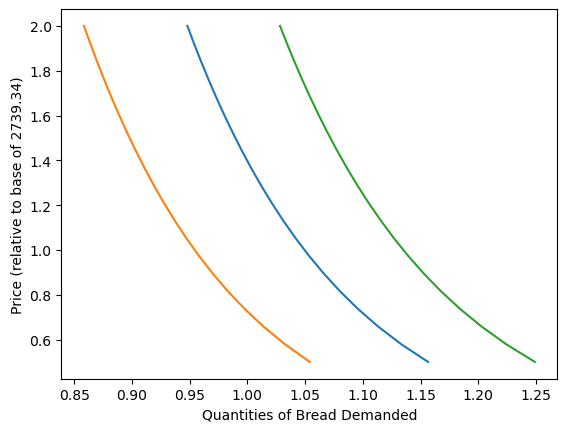

In [40]:
import matplotlib.pyplot as plt

use = 'Bread'  # Good we want demand curve for

# Vary prices from 50% to 200% of reference.
scale = np.linspace(.5,2,20)

# Demand for Matoke for household at median budget
plt.plot([r.demands(xref,my_prices(use,pbar[use]*s,pbar))[use] for s in scale],scale)

# Demand for Matoke for household at 25% percentile
plt.plot([r.demands(xbar.quantile(0.25),my_prices(use,pbar[use]*s,pbar))[use] for s in scale],scale)

# Demand for Matoke for household at 75% percentile
plt.plot([r.demands(xbar.quantile(0.75),my_prices(use,pbar[use]*s,pbar))[use] for s in scale],scale)

plt.ylabel(f"Price (relative to base of {pbar[use]:.2f})")
plt.xlabel(f"Quantities of {use} Demanded")

#### Engel Curves



/srv/conda/lib/python3.11/site-packages/consumerdemands/root_with_precision.py:83: UserWarning: Tolerance is set to 1.00E-12.  Change in value is -8.59E+09.  Iterations are 1001.  Perhaps tolerance is too high?
  warn("Tolerance is set to %.2E.  Change in value is %.2E.  Iterations are %d.  Perhaps tolerance is too high?" % (tol,x[0]-x[-1],i))


Text(0.5, 1.0, 'Engel Curves')

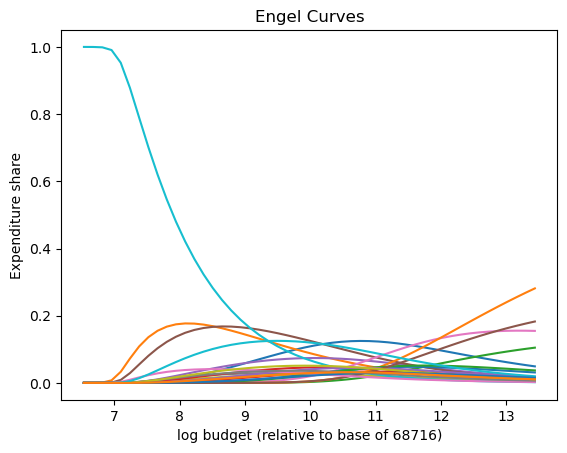

In [41]:
fig,ax = plt.subplots()

scale = np.geomspace(.01,10,50)

ax.plot(np.log(scale*xref),[r.expenditures(s*xref,pbar)/(s*xref) for s in scale])
ax.set_xlabel(f'log budget (relative to base of {xref:.0f})')
ax.set_ylabel(f'Expenditure share')
ax.set_title('Engel Curves')

### Mapping to Nutrients



We&rsquo;ve seen how to map prices and budgets into vectors of consumption
 quantities using `cfe.Regression.demands`.  Next we want to think about
 how to map these into bundles of *nutrients*.  The information needed
 for the mapping comes from a &ldquo;Food Conversion Table&rdquo; (or database,
 such as the [USDA Food Data Central](https://fdc.nal.usda.gov/)).    We&rsquo;ve already grabbed an FCT, let&rsquo;s take a look:



In [42]:
fct

n,Energy,Protein,Vitamin A,Vitamin D,Vitamin E,Vitamin C,Vitamin B-6,Vitamin B-12,Calcium,Magnesium,Iron,Zinc
j,,,,,,,,,,,,
Beef,3230,249,0,0,0,0,3,19,40,230,17,41
Bottled beer,410,3,0,0,0,0,1,0,50,60,0,0
Bread,2740,80,0,0,0,0,0,0,100,270,5,9
Butter,8760,3,9250,20,30,0,0,0,80,10,1,0
Canned milk/milk powder,4960,263,4070,0,0,70,4,30,8510,810,7,30
...,...,...,...,...,...,...,...,...,...,...,...,...
"Wheat, barley grain and other cereals",3490,123,0,0,10,0,2,0,260,920,28,20
"Wheat, barley, other grains",3490,123,0,0,10,0,2,0,260,920,28,20
Wild birds and insects,0,0,0,0,0,0,0,0,0,0,0,0


We need the index of the Food Conversion Table (FCT) to match up with
 the index of the vector of quantities demanded.   To manage this we
 make use of the `align` method for `pd.DataFrames`:



In [43]:
# Create a new FCT and vector of consumption that only share rows in common:
fct0,c0 = fct.align(qhat.T,axis=0,join='inner')
print(fct0.index)

Index(['Beef', 'Bread', 'Coconuts', 'Eggs', 'Maize (flour)', 'Plantains',
       'Rice (husked)', 'Salt', 'Soft drinks', 'Sugar', 'Tea (dry)'],
      dtype='object', name='j')


Now, since rows of `fct0` and `c0` match, we can obtain nutritional
 outcomes from the inner (or dot, or matrix) product of the transposed
 `fct0` and `c0`:



In [100]:
# The @ operator means matrix multiply
N = fct0.T@c0

N  #NB: tanzania quantities are for previous 7 days

i,1009-001-01,1025-001-02,1039-001-01,1078-001-01,1102-001-01,1142-001-01,1196-001-01,1213-001-01,1232-001-01,1248-001-01,...,9700-001-99,9712-001-99,9724-001-99,9736-001-99,9748-001-99,9760-001-99,9772-001-99,9784-001-99,9796-001-99,9808-001-99
t,2020-21,2020-21,2020-21,2020-21,2020-21,2020-21,2020-21,2020-21,2020-21,2020-21,...,2020-21,2020-21,2020-21,2020-21,2020-21,2020-21,2020-21,2020-21,2020-21,2020-21
m,Mainland Rural,Mainland Other Urban,Mainland Other Urban,Mainland Rural,Mainland Rural,Dar Es Salaam,Dar Es Salaam,Dar Es Salaam,Dar Es Salaam,Dar Es Salaam,...,Mainland Other Urban,Mainland Other Urban,Mainland Other Urban,Mainland Other Urban,Mainland Other Urban,Mainland Other Urban,Mainland Other Urban,Mainland Other Urban,Mainland Other Urban,Mainland Other Urban
n,,,,,,,,,,,,,,,,,,,,,
Energy,44087.318809,16769.270870,41518.682749,57320.880662,42409.907393,27905.489944,49345.612502,36335.124460,69333.292985,23162.197227,...,40450.936899,50829.317743,36169.507155,29179.558570,30525.344948,43567.120264,40333.103762,29572.327496,43955.747391,54783.462041
Protein,1062.545610,429.968487,1024.038142,1366.876220,981.947552,646.942036,1117.787045,831.499919,1433.964216,538.896893,...,999.210716,1188.060630,873.503137,704.006590,806.581209,1056.859257,942.785554,765.840639,1075.348110,1203.658416
Vitamin A,4818.518265,2934.521852,4889.938052,8751.074792,5526.708962,3757.583366,6166.786407,3271.267201,13251.725010,3163.566674,...,6284.146278,3203.688769,6048.940185,4367.564952,4858.745897,6288.806170,4250.830309,4893.130266,6972.717766,7715.740138
Vitamin D,29.299713,16.990846,33.532951,66.582775,34.381574,20.803799,34.057158,17.869075,34.159687,16.060944,...,50.361435,17.231828,36.473919,30.259248,27.933261,41.838661,28.665312,38.171501,44.869676,33.470607
Vitamin E,55.470505,18.238610,40.799003,90.447305,82.577158,27.351696,59.822557,27.844569,41.483619,21.066745,...,64.976369,46.315703,37.579119,29.076995,29.983627,40.095619,51.751641,41.244285,48.572322,62.899275
Vitamin C,192.370932,120.356474,151.905206,195.165668,191.369729,162.826634,266.367026,156.787558,892.729708,155.469966,...,117.473999,172.294829,235.703894,136.510380,208.064575,221.691047,141.187281,107.991499,247.442998,409.592260
Vitamin B-6,23.812285,8.606190,19.609942,33.663430,28.320776,13.665174,26.539859,16.078028,31.003139,11.238596,...,24.184075,24.085708,18.315252,13.941657,15.755356,20.874400,21.255676,16.500927,22.909678,28.426592


Of course, since we can compute the nutritional content of a vector of
 consumption goods `c0`, we can also use our demand functions to
 compute nutrition as a *function* of prices and budget.



In [101]:
def nutrient_demand(x,p):
    c = r.demands(x,p)
    fct0,c0 = fct.align(c,axis=0,join='inner')
    N = fct0.T@c0

    N = N.loc[~N.index.duplicated()]
    
    return N

With this `nutrient_demand` function in hand, we can see how nutrient
 outcomes vary with budget, given prices:



In [102]:
X = np.linspace(xref/5,xref*5,50)

In [103]:
def nutrient_outcomes_by_budget(nutrientsused, pbar, X):
    X = X
    
    UseNutrients = nutrientsused
    
    df = pd.concat({myx:np.log(nutrient_demand(myx,pbar))[UseNutrients] for myx in X},axis=1).T
    ax = df.plot()
    
    ax.set_xlabel('log budget')
    ax.set_ylabel('log nutrient')

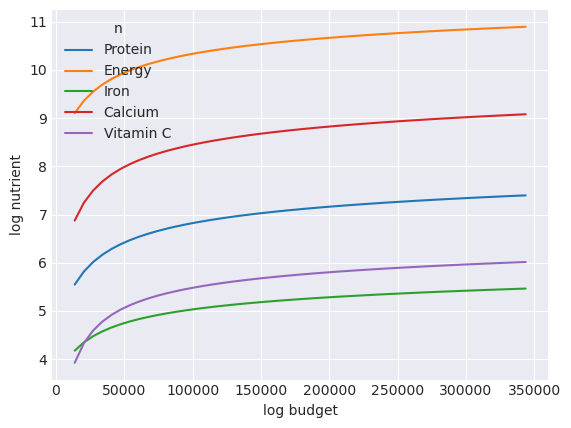

In [104]:
nutrient_outcomes_by_budget(['Protein','Energy','Iron','Calcium','Vitamin C'], pbar, X)

Now how does nutrition vary with prices?



Text(0, 0.5, 'log nutrient')

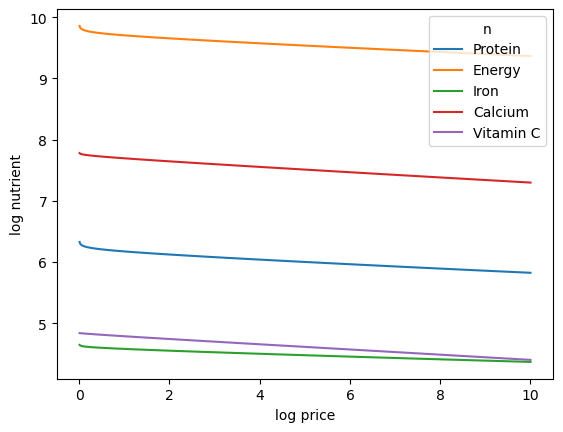

In [49]:
USE_GOOD = 'Bread'

scale = np.geomspace(.01,10,50)

ndf = pd.DataFrame({s:np.log(nutrient_demand(xref/2,my_prices(USE_GOOD,pbar[USE_GOOD]*s)))[UseNutrients] for s in scale}).T

ax = ndf.plot()

ax.set_xlabel('log price')
ax.set_ylabel('log nutrient')

### Nutritional Needs of Households



Our data on demand and nutrients is at the *household* level; we
   can&rsquo;t directly compare household level nutrition with individual
   level requirements.  What we **can** do is add up minimum individual
   requirements, and see whether household total exceed these.  This
   isn&rsquo;t a guarantee that all individuals have adequate nutrition
   (since the way food is allocated in the household might be quite
   unequal, or unrelated to individual requirements), but it is
   *necessary* if all individuals are to have adequate nutrition.

For the average household in our data, the number of
different kinds of people can be computed by averaging over households:



In [113]:
# In first round, averaged over households and villages
dbar = r.d[rdi.columns].mean()

Now, the inner/dot/matrix product between `dbar` and the `rdi`
DataFrame of requirements will give us minimum requirements for the
average household:



In [114]:
# This matrix product gives minimum nutrient requirements for
# the average household
hh_rdi = rdi@dbar

hh_rdi

n
Energy           9638.461538
Protein           216.948718
Fiber             134.938462
Folate           1813.846154
Calcium          5838.974359
Carbohydrate      713.000000
Iron               59.161538
Magnesium        1559.025641
Niacin             69.071795
Phosphorus       4342.358974
Potassium       23955.128205
Riboflavin          5.420769
Thiamin             5.260513
Vitamin A        3613.846154
Vitamin B-12       10.883077
Vitamin B-6         6.031282
Vitamin C         328.807692
Vitamin E          67.587179
Vitamin K         434.935897
Zinc               43.776923
dtype: float64

## Nutritional Adequacy of Food Demands



Since we can trace out demands for nutrients as a function of $(x,p)$,
and we&rsquo;ve computed minimum nutritional requirements for the average
household, we can *normalize* nutritional intake to check the adequacy
of diet for a household with counts of different kinds of people given by `z`.



In [115]:
def nutrient_adequacy_ratio(x,p,d,rdi=rdi,days=7):
    hh_rdi = rdi.replace('',0)@d*days

    return nutrient_demand(x,p)/hh_rdi

In terms of normalized nutrients, any household with more than one
unit of any given nutrient (or zero in logs) will be consuming a
minimally adequate level of the nutrient; below this level there&rsquo;s
clearly nutritional inadequacy.  For this reason the ratio of
actual nutrients to required nutrients is termed the &ldquo;nutrient
adequacy ratio,&rdquo; or NAR.



In [116]:
def nutritional_adequacy_graph(x,pbar,dbar):
    X = np.geomspace(.01*xref,2*xref,100)
    
    pd.DataFrame({x:np.log(nutrient_adequacy_ratio(x,pbar,dbar))[UseNutrients] for x in X}).T.plot()
    plt.legend(UseNutrients)
    plt.xlabel('budget')
    plt.ylabel('log nutrient adequacy ratio')
    plt.axhline(0)
    plt.axvline(xref)
    plt.title('Log Nutrient Adequacy Ratio vs. Budget')

/srv/conda/lib/python3.11/site-packages/consumerdemands/root_with_precision.py:83: UserWarning: Tolerance is set to 1.00E-12.  Change in value is -1.80E+16.  Iterations are 1001.  Perhaps tolerance is too high?
  warn("Tolerance is set to %.2E.  Change in value is %.2E.  Iterations are %d.  Perhaps tolerance is too high?" % (tol,x[0]-x[-1],i))
/srv/conda/lib/python3.11/site-packages/consumerdemands/root_with_precision.py:83: UserWarning: Tolerance is set to 1.00E-12.  Change in value is -3.52E+13.  Iterations are 1001.  Perhaps tolerance is too high?
  warn("Tolerance is set to %.2E.  Change in value is %.2E.  Iterations are %d.  Perhaps tolerance is too high?" % (tol,x[0]-x[-1],i))
/srv/conda/lib/python3.11/site-packages/consumerdemands/root_with_precision.py:83: UserWarning: Tolerance is set to 1.00E-12.  Change in value is -6.87E+10.  Iterations are 1001.  Perhaps tolerance is too high?
  warn("Tolerance is set to %.2E.  Change in value is %.2E.  Iterations are %d.  Perhaps toleranc

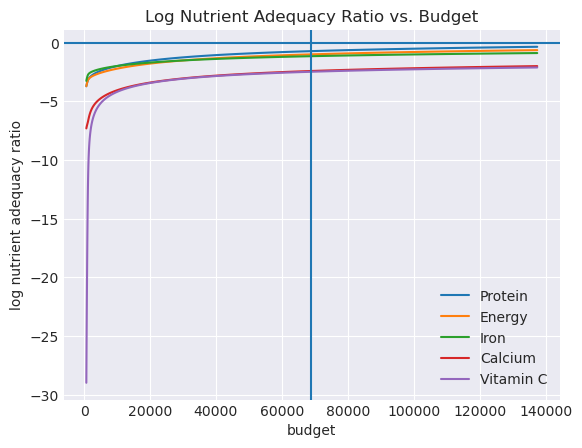

In [117]:
nutritional_adequacy_graph(x,pbar,dbar)

Do research on effectiveness of cash transfers -> how directly will they impact nutritional outcomes and would some subsidies be better?

As before, we can also vary relative prices.  Here we trace out
nutritional adequacy varying the price of a single good:



Text(0.5, 0, 'log nutrient adequacy ratio')

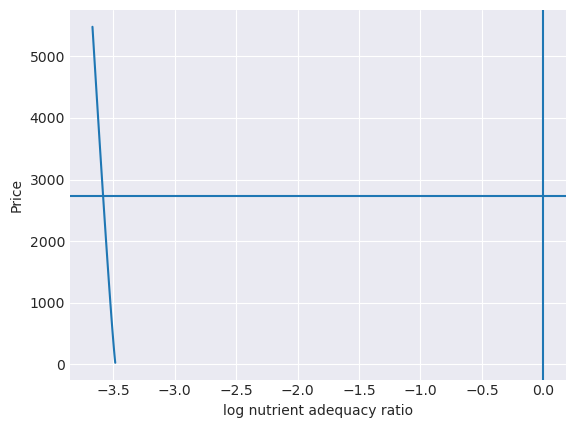

In [118]:
scale = np.geomspace(.01,2,50)

ndf = pd.DataFrame({s*pbar[USE_GOOD]:np.log(nutrient_adequacy_ratio(xref/4,my_prices(USE_GOOD,pbar[USE_GOOD]*s),dbar))[UseNutrients] for s in scale}).T

fig,ax = plt.subplots()
ax.plot(ndf['Vitamin C'],ndf.index)
ax.axhline(pbar[USE_GOOD])
ax.axvline(0)

ax.set_ylabel('Price')
ax.set_xlabel('log nutrient adequacy ratio')

In [92]:
x0 = xbar.quantile(0.5)  # Household at 0.5 quantile is medianf

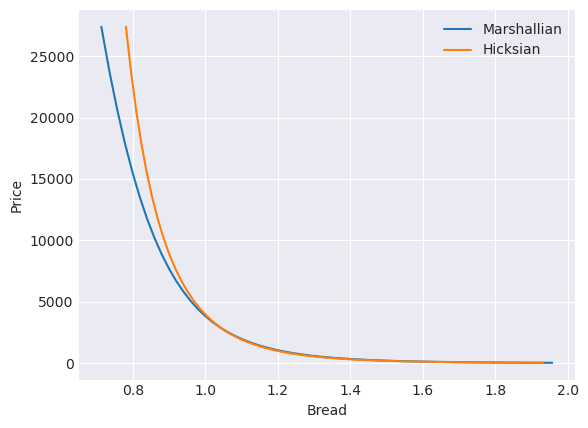

In [94]:
import matplotlib.pyplot as plt
%matplotlib inline

my_j = 'Bread'  # Interesting Ugandan staple

P = np.geomspace(.01,10,50)*pbar[my_j]

# Utility of median household, given prices
U0 = r.indirect_utility(x0,pbar)

plt.plot([r.demands(x0,my_prices(my_j,p0))[my_j] for p0 in P],P)
plt.plot([r.demands(U0,my_prices(my_j,p0),type="Hicksian")[my_j] for p0 in P],P)
plt.ylabel('Price')
plt.xlabel(my_j)
plt.legend(("Marshallian","Hicksian"))

# wrapping it all into one good analysis function

In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def analyze_good(
    good: str,
    r,
    x0,
    pbar: pd.Series,
    dbar: pd.Series,
    xref: float,
    UseNutrients: list[str],
    nutrient_demand,
    nutrient_adequacy_ratio,
    price_multipliers: np.ndarray = None,
    budget_multipliers: np.ndarray = None,
    figsize: tuple = (12, 16)
):
    """
    - Varies pbar[good] over `price_multipliers` and replots:
        1) Marshallian vs Hicksian demand
        2) Log nutrient adequacy vs Price
        3) Log nutrient adequacy vs Budget
    - Assumes pbar already holds your baseline (and any other shocks).
    """
    # defaults
    if price_multipliers is None:
        price_multipliers = np.geomspace(0.01, 10, 50)
    if budget_multipliers is None:
        budget_multipliers = np.geomspace(0.01, 2, 50)

    # 1) Demand curves
    prices = price_multipliers * pbar[good]
    U0 = r.indirect_utility(x0, pbar)
    q_marshall, q_hicksian = [], []
    for p in prices:
        pvec = pbar.copy(); pvec[good] = p
        q_marshall.append(r.demands(x0, pvec)[good])
        q_hicksian.append(r.demands(U0, pvec, type="Hicksian")[good])

    # 2) Nutrient adequacy vs. Price
    nar_price_dict = {}
    for p in prices:
        pvec = pbar.copy(); pvec[good] = p
        nar = nutrient_adequacy_ratio(xref/4, pvec, dbar)
        nar_price_dict[p] = np.log(nar[UseNutrients])
    nar_vs_price = pd.DataFrame(nar_price_dict).T

    # 3) Nutrient adequacy vs. Budget
    budgets = budget_multipliers * xref
    nar_budget_dict = {}
    for b in budgets:
        nar_b = nutrient_demand(b, pbar)
        nar_budget_dict[b] = np.log(nar_b[UseNutrients])
    nar_vs_budget = pd.DataFrame(nar_budget_dict).T

    # Plot setup
    fig, axes = plt.subplots(3, 1, figsize=figsize, constrained_layout=True)

    # -- Plot 1: Demand Curves --
    ax = axes[0]
    ax.plot(q_marshall, prices, lw=2, label='Marshallian')
    ax.plot(q_hicksian, prices, lw=2, label='Hicksian')
    ax.set_title(f"{good}: Marshallian vs. Hicksian Demand", fontweight='bold')
    ax.set_xlabel(f"Quantity of {good}", fontweight='bold')
    ax.set_ylabel("Price", fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.text(0.5, -0.2,
            "Marshallian: demand at fixed income; Hicksian: compensated demand.",
            ha='center', va='top', transform=ax.transAxes, style='italic')

    # -- Plot 2: Nutrient Adequacy vs. Price --
    ax = axes[1]
    for nut in nar_vs_price.columns:
        ax.plot(nar_vs_price[nut], nar_vs_price.index, lw=2, label=nut)
    ax.set_title(f"{good}: Log Nutrient Adequacy vs. Price", fontweight='bold')
    ax.set_xlabel("Log Nutrient Adequacy Ratio", fontweight='bold')
    ax.set_ylabel("Price", fontweight='bold')
    ax.axhline(pbar[good], color='gray', ls='--', lw=1)
    ax.axvline(0, color='gray', ls='--', lw=1)
    ax.legend(title="Nutrient")
    ax.grid(alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.text(0.5, -0.2,
            "Each curve shows how adequacy changes as the staple's price varies.",
            ha='center', va='top', transform=ax.transAxes, style='italic')

    # -- Plot 3: Nutrient Adequacy vs. Budget --
    ax = axes[2]
    for nut in nar_vs_budget.columns:
        ax.plot(nar_vs_budget[nut], nar_vs_budget.index, lw=2, label=nut)
    ax.set_title(f"{good}: Log Nutrient Adequacy vs. Budget", fontweight='bold')
    ax.set_xlabel("Log Nutrient Adequacy Ratio", fontweight='bold')
    ax.set_ylabel("Budget", fontweight='bold')
    ax.axhline(0, color='gray', ls='--', lw=1)
    ax.legend(title="Nutrient")
    ax.grid(alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.text(0.5, -0.2,
            "Each curve shows how adequacy changes as total budget varies.",
            ha='center', va='top', transform=ax.transAxes, style='italic')

    plt.show()


/srv/conda/lib/python3.11/site-packages/consumerdemands/root_with_precision.py:83: UserWarning: Tolerance is set to 1.00E-12.  Change in value is -1.76E+13.  Iterations are 1001.  Perhaps tolerance is too high?
  warn("Tolerance is set to %.2E.  Change in value is %.2E.  Iterations are %d.  Perhaps tolerance is too high?" % (tol,x[0]-x[-1],i))
/srv/conda/lib/python3.11/site-packages/consumerdemands/root_with_precision.py:83: UserWarning: Tolerance is set to 1.00E-12.  Change in value is -1.46E-11.  Iterations are 1001.  Perhaps tolerance is too high?
  warn("Tolerance is set to %.2E.  Change in value is %.2E.  Iterations are %d.  Perhaps tolerance is too high?" % (tol,x[0]-x[-1],i))


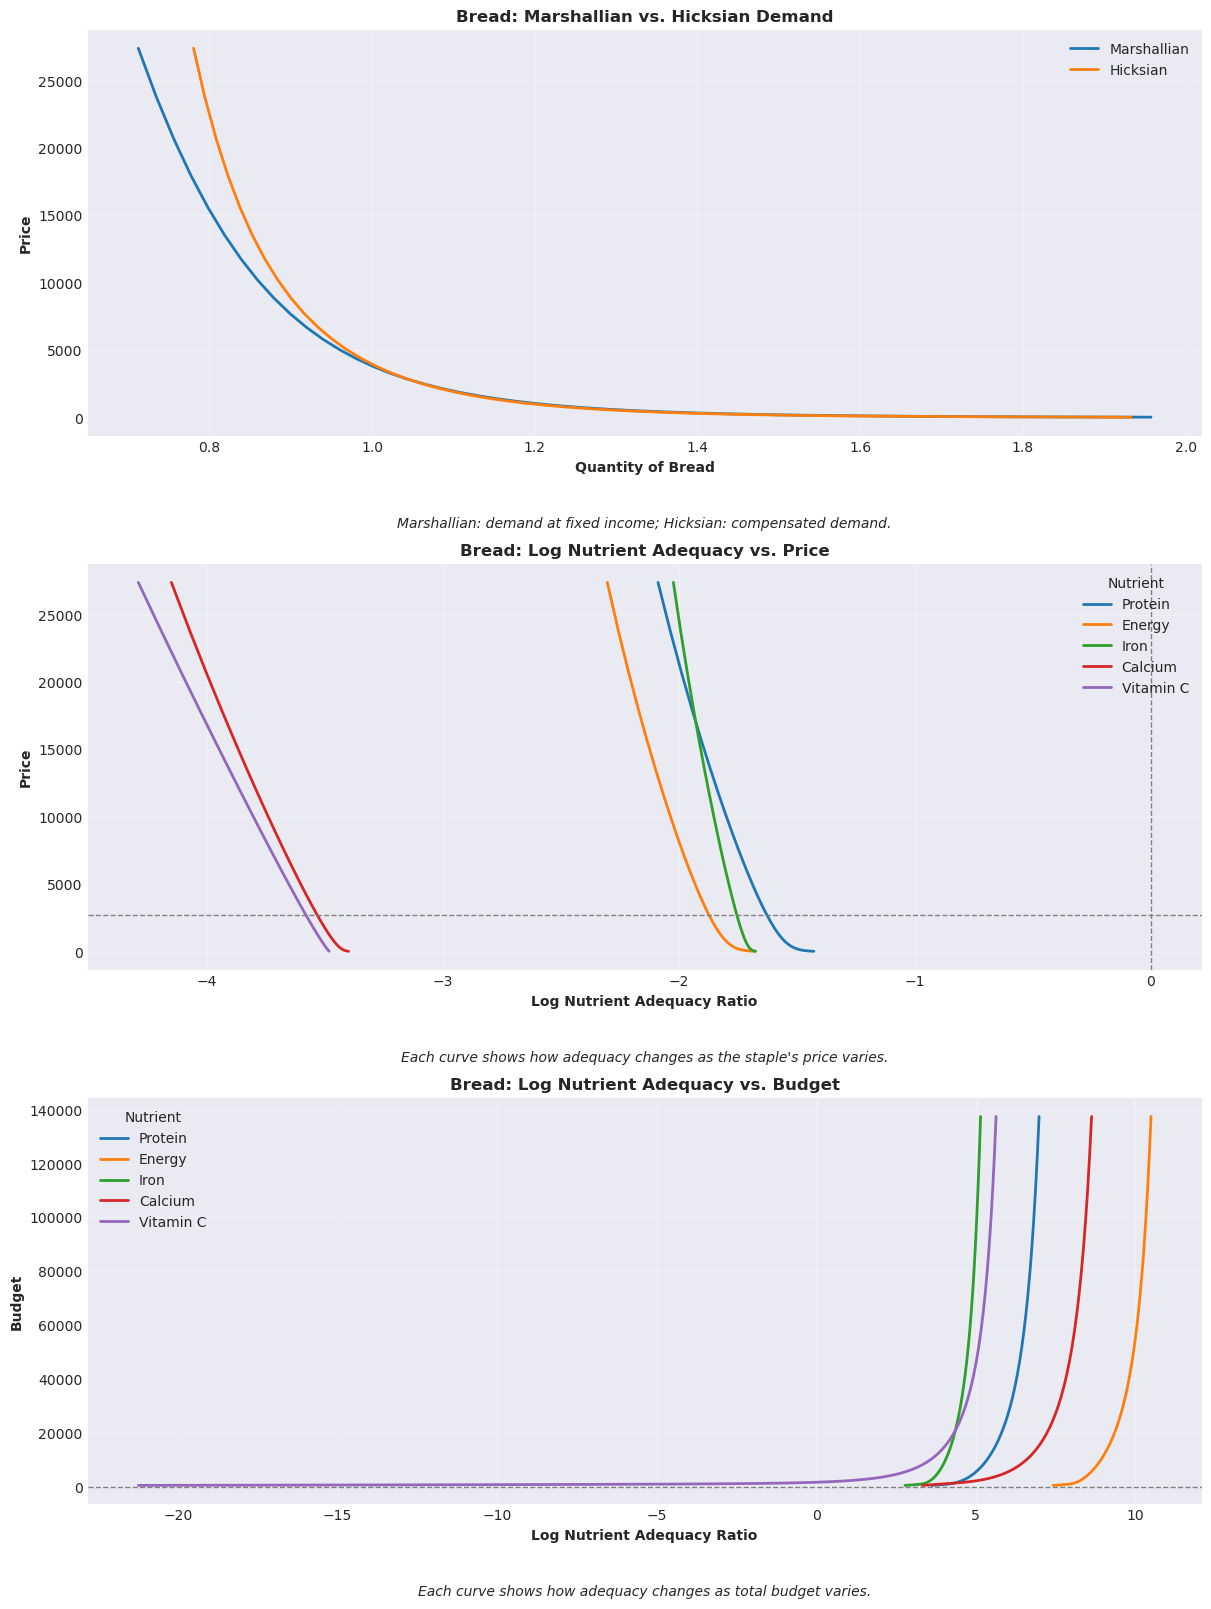

In [124]:
analyze_good(
    good='Bread',
    r=r,
    x0=x0,
    pbar=pbar,
    dbar=dbar,
    xref=xref,
    UseNutrients=UseNutrients,
    nutrient_demand=nutrient_demand,
    nutrient_adequacy_ratio=nutrient_adequacy_ratio
)
